In [9]:
import pandas as pd

In [28]:
import matplotlib.pyplot as plt

In [31]:
import seaborn as sns

In [10]:
bom_movie_gross = pd.read_csv("../data/bom.movie_gross.csv.gz")

In [11]:
imdb_name_basics = pd.read_csv("../data/imdb.name.basics.csv.gz")

In [12]:
imdb_title_akas = pd.read_csv("../data/imdb.title.akas.csv.gz")

In [13]:
imdb_title_basics = pd.read_csv("../data/imdb.title.basics.csv.gz")

In [14]:
imdb_title_crew = pd.read_csv("../data/imdb.title.crew.csv.gz")

In [15]:
imdb_title_principals = pd.read_csv("../data/imdb.title.principals.csv.gz")

In [16]:
imdb_title_ratings = pd.read_csv("../data/imdb.title.ratings.csv.gz")

In [17]:
rt_movie_info = pd.read_csv("../data/rt.movie_info.tsv.gz", sep='\t')

In [18]:
# Come back to this later rt_reviews = pd.read_csv("../data/rt.reviews.tsv.gz")

In [19]:
tmdb_movies = pd.read_csv("../data/tmdb.movies.csv.gz")

In [20]:
tn_movie_budgets = pd.read_csv("../data/tn.movie_budgets.csv.gz")

In [29]:
%matplotlib inline

# Creating Lists and Graphs and Things

In [45]:
s1 = pd.merge(imdb_title_basics, imdb_title_ratings, how='inner')

In [43]:
s1 = s1.loc[s1["numvotes"] > 100000 ] #Remove the chaff also known as anything not popular enough to garner 100k votes

In [46]:
s1.sort_values("averagerating",  ascending=False) # Sort by "average rating"

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
51109,tt5089804,Fly High: Story of the Disc Dog,Fly High: Story of the Disc Dog,2019,65.0,Documentary,10.0,7
65944,tt7259300,Calamity Kevin,Calamity Kevin,2019,77.0,"Adventure,Comedy",10.0,6
71577,tt8730716,Pick It Up! - Ska in the '90s,Pick It Up! - Ska in the '90s,2019,99.0,Documentary,10.0,5
73616,tt9715646,Renegade,Renegade,2019,NaN,Documentary,10.0,20
65755,tt7227500,Ellis Island: The Making of a Master Race in A...,Ellis Island: The Making of a Master Race in A...,2018,70.0,"Documentary,History",10.0,6
878,tt10378660,The Dark Knight: The Ballad of the N Word,The Dark Knight: The Ballad of the N Word,2018,129.0,"Comedy,Drama",10.0,5
64646,tt6991826,A Dedicated Life: Phoebe Brand Beyond the Group,A Dedicated Life: Phoebe Brand Beyond the Group,2015,93.0,Documentary,10.0,5
9745,tt1770682,Freeing Bernie Baran,Freeing Bernie Baran,2010,100.0,"Crime,Documentary",10.0,5
702,tt10176328,Exteriores: Mulheres Brasileiras na Diplomacia,Exteriores: Mulheres Brasileiras na Diplomacia,2018,52.0,Documentary,10.0,5
49925,tt4944240,Dog Days in the Heartland,Dog Days in the Heartland,2017,NaN,Drama,10.0,5


So I want to first sort by "averagerating", because if we're going to claim to know what type of movie Microsoft Film Studios should make like some kind of mystic, we may as tell them we aim to be compared to the best of the best.  But they also need to have a certain amount of weight, or proof which comes for better or worse throgh "numvotes", because strength in numbers. 

In [34]:
tips = sns.load_dataset('tips')

In [38]:
s1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618 entries, 47 to 68488
Data columns (total 8 columns):
tconst             618 non-null object
primary_title      618 non-null object
original_title     618 non-null object
start_year         618 non-null int64
runtime_minutes    618 non-null float64
genres             618 non-null object
averagerating      618 non-null float64
numvotes           618 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 63.5+ KB


# Plot average rating over the y-axis, movies with greater "numvotes" have a more opaque color whereas the movies with less are transparent. X-Axis displays names? vvvv

In [47]:
s1["averagerating"]

0        7.0
1        7.2
2        6.9
3        6.1
4        6.5
5        4.1
6        8.1
7        6.8
8        4.6
9        7.6
10       6.9
11       7.5
12       7.8
13       4.0
14       8.8
15       4.0
16       1.9
17       6.7
18       6.6
19       5.9
20       7.8
21       7.1
22       7.4
23       7.0
24       6.6
25       3.9
26       7.4
27       6.6
28       6.7
29       5.5
        ... 
73826    8.2
73827    7.9
73828    8.7
73829    6.2
73830    4.9
73831    8.1
73832    5.8
73833    9.0
73834    7.8
73835    7.2
73836    8.5
73837    9.2
73838    7.3
73839    2.6
73840    8.7
73841    8.1
73842    8.4
73843    9.3
73844    9.0
73845    8.1
73846    4.2
73847    7.0
73848    6.1
73849    8.4
73850    6.2
73851    6.2
73852    8.7
73853    8.5
73854    6.6
73855    6.5
Name: averagerating, Length: 73856, dtype: float64

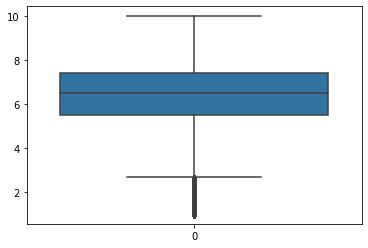

In [48]:
boxplot = sns.boxplot(data=s1["averagerating"])